In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
path_to_ml_20m = "data/upgraded/"

In [3]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import itertools
import time
import umap
import paths

def plot_pareto2(most_stable, all_stable_paths, save=False):
    # stabs = [p[1] for p in most_stable.values()]
    # lens = list(most_stable.keys())
        
    unoptimal_paths = np.array([(n, s[1]) for n, ps in all_stable_paths.items() for s in ps])
    optimal_paths = np.array([(n,ps[1]) for n, ps in most_stable.items()])

    ax = plt.figure(figsize=(20,10)).gca()  
    ax.xaxis.set_major_locator(MaxNLocator(integer=True)) 
    plt.subplot(111)
    
    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20) 

    cmap = plt.get_cmap('tab10')
    plt.scatter(unoptimal_paths[:,0], unoptimal_paths[:,1], color=cmap(1), label='Nonoptimal paths')
    plt.scatter(optimal_paths[:,0], optimal_paths[:,1], label='Optimal paths')
    plt.plot(optimal_paths[:,0], optimal_paths[:,1], label='Pareto frontier')


    plt.xlabel("Length of path")
    plt.ylabel("Instability of path")

    plt.legend()
    ticks = range(int(min(optimal_paths[:,0])), int(max(optimal_paths[:,0])) + 1)
    plt.xticks(ticks)
    if save!=False:
        plt.savefig(save,)


#from cechmate import Cover
class BaseFiltration:
    def __init__(self, max_dim=3):
        
        self.max_dim = max_dim
        
        
class Cover(BaseFiltration):
    def __init__(self, max_dim):
        super().__init__(max_dim)
        self.covers = None
        self.simplices = None
        self.dists = []  
    
    def build(self, covers):

        # Give each cover element a name.
        if not isinstance(covers, dict):
            covers = dict(enumerate(covers))
            
        simplices = [([k], 0.0) for k in covers.keys()]
        
        # TODO: be more intelligent about which combos we check

        #Changed self.max_dim+1 to self.max_dim+2. Correct?
        for k in range(2, self.max_dim + 2):
            for potentials in itertools.combinations(covers.keys(), k):
                potential_sets = [covers[p] for p in potentials]

                d = self.jaccard(potential_sets)
                self.dists.append(d)

                # TODO: Do we want to include all of these simplices as well?
                if d < 1:
                    simplices.append((potentials, d))
        
        self.covers = covers
        self.simplices = simplices
        self.d = d
        
        return simplices

    def jaccard(self, covers):
        covers_as_sets = list(map(set, covers))
        intersection = set.intersection(*covers_as_sets)
        union = set.union(*covers_as_sets)

        return 1 - len(intersection) / len(union)


__all__ = ['Cover']

%matplotlib inline

pd.options.display.max_rows = 8

## Choose 5 particular genres

In [4]:
"""
Possible genres:

Action
Adventure
Animation
Children's
Comedy
Crime
Documentary
Drama
Fantasy
Film-Noir
Horror
Musical
Mystery
Romance
Sci-Fi
Thriller
War
Western
(no genres listed)
"""

#MAJOR_CATS = ['Action', 'Drama', 'Comedy', 'Romance', 'Horror']
#MAJOR_CATS = ['Adventure', "Children", "Musical", "Sci-Fi", "Western"]

# BAD_CATS = ['Film-Noir', '(no genre listed)']

"\nPossible genres:\n\nAction\nAdventure\nAnimation\nChildren's\nComedy\nCrime\nDocumentary\nDrama\nFantasy\nFilm-Noir\nHorror\nMusical\nMystery\nRomance\nSci-Fi\nThriller\nWar\nWestern\n(no genres listed)\n"

## Load ratings

In [5]:
ratings = pd.read_csv(os.path.join(path_to_ml_20m, "pls_songs.csv"), delimiter=",")


In [6]:
ratings = ratings.drop(columns = 'Unnamed: 0')

In [7]:
ratings.head()

,pid,id,track_uri,genres
0,0,0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,"dance pop,hip hop,hip pop,pop rap,r&b,rap,urba..."
1,0,1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,"dance pop,pop"
2,0,2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,"dance pop,pop,r&b"
3,0,3,spotify:track:1AWQoqb9bSvzTjaLralEkT,"dance pop,pop"
4,0,4,spotify:track:1lzr43nnXAijIGYnCT8M8H,"dance pop,pop rap,reggae fusion"


In [8]:
ratings

,pid,id,track_uri,genres
0,0,0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,"dance pop,hip hop,hip pop,pop rap,r&b,rap,urba..."
1,0,1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,"dance pop,pop"
2,0,2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,"dance pop,pop,r&b"
3,0,3,spotify:track:1AWQoqb9bSvzTjaLralEkT,"dance pop,pop"
...,...,...,...,...
66346424,999999,288294,spotify:track:3wqJC3yJBN2eSKVuEpQj9w,"banda,musica mexicana,nueva musica mexicana,ra..."
66346425,999999,141054,spotify:track:1YcTGCPO4dRnFWVBvuWEKa,"banda,musica mexicana,nueva musica mexicana,ra..."
66346426,999999,141039,spotify:track:0nAyEpfdIFHTXkIISI3Ke7,"banda,musica mexicana,nueva musica mexicana,ra..."
66346427,999999,72395,spotify:track:35oKShiPehjQg7y1iTIQ0E,"banda,musica mexicana,nueva musica mexicana,ra..."


## Load movies information

In [9]:
movie_info = pd.read_csv(os.path.join(path_to_ml_20m, "tracks.csv"), delimiter=",")


In [10]:
movie_info = movie_info.dropna()
movie_info = movie_info.drop(columns = 'id.1')

In [11]:
genre_to_use = 'hard rock'
mask = movie_info.loc[movie_info.genres.str.contains(genre_to_use)]

In [12]:
movie_info.head()

,id,track_uri,track_name,artist_name,genres
0,0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),Missy Elliott,"dance pop,hip hop,hip pop,pop rap,r&b,rap,urba..."
1,1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Toxic,Britney Spears,"dance pop,pop"
2,2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,Beyoncé,"dance pop,pop,r&b"
3,3,spotify:track:1AWQoqb9bSvzTjaLralEkT,Rock Your Body,Justin Timberlake,"dance pop,pop"
4,4,spotify:track:1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,Shaggy,"dance pop,pop rap,reggae fusion"


In [13]:
toxic = 1
toxicity = 2516
thriller = 304

carryonmywayward = 74
bohemian = 75

helpbeatles = 475
shapeofu= 1064

""""

transformers = 53996
notebook = 8533
princess = 1197

darko = 4878
chainsaw = 6880

mulan = 1907 
rouge = 4308
""" 

'"\n\ntransformers = 53996\nnotebook = 8533\nprincess = 1197\n\ndarko = 4878\nchainsaw = 6880\n\nmulan = 1907 \nrouge = 4308\n'

- Toxic -> Toxicity
- Toxicity -> Bolero...

- Transformers $\to$ The Notebook 
- The Princess Bride $\to$ Donnie Darko
- Texas Chainsaw Massacre $\to$ Mulan
- Mulan $\to$ Moulin Rouge

## Filter movies to only particular subset

- filter out lots of movies that won't matter 
- ones that only have a few ratings




In [14]:
%%time
movies = ratings.groupby('id')

movies_map = {name: list(group.pid) for name, group in movies}
movies_ratings_n = [len(m) for m in movies_map.values()]


Wall time: 4min 45s


In [15]:
len(movies)

2262292

In [16]:
movies_ratings_n[1]

13205

In [17]:
len(movies_ratings_n)

2262292

In [18]:
print(len(movies_ratings_n))
print(len([n for n in movies_ratings_n if n >= 2]))

2262292
1188873


In [19]:
mask['id'].values

array([     51,      64,      70, ..., 2262127, 2262128, 2262130],
      dtype=int64)

In [20]:
%%time
slim_movies_map = {name: ls for name, ls in movies_map.items() if len(ls) >= 3}

toxic = 1
toxicity = 2516
thriller = 304

carryonmywayward = 74
bohemian = 75

helpbeatles = 475
shapeofu = 1064


good_movies = [toxic, toxicity,thriller, carryonmywayward,bohemian, helpbeatles,shapeofu]
np.random.seed(1)

#rate = 800 / len(movies_map)
#slimer_movies_map = {name: ls for name, ls in movies_map.items() 
#                     if np.random.random() <= rate or name in good_movies}

slimer_movies_map = {name: ls for name, ls in movies_map.items() 
                     if name in mask['id'].values}

Wall time: 45.6 s


In [21]:
len(movies_map)

2262292

In [22]:
len(slimer_movies_map)

26440

In [23]:
print(rate)

NameError: name 'rate' is not defined

In [24]:
len(slimer_movies_map)

26440

In [25]:
1000. / len(movies_map)

0.0004420295876924818

In [26]:
%%time
for m in good_movies:
    assert m in slimer_movies_map.keys()

AssertionError: 

In [27]:
"""
%%time
filt = lambda x: '|'.join(set(x.split('|')).intersection(MAJOR_CATS))
isin = lambda x: len(set(x.split('|')).intersection(MAJOR_CATS)) > 0
def get_year(x):
    try:
        return int(x.strip()[-6:][1:-1])
    except:
        return 1


movie_info['year'] = movie_info['title'].apply(get_year)

# movie_info = movie_info[movie_info['year'] > 2000]
# movie_info['major_cat'] = movie_info['genres'].apply(isin)
# movie_info['genres'] = movie_info['genr es'].apply(filt)
# movie_info = movie_info[movie_info['major_cat'] == True]
movie_info
"""

"\n%%time\nfilt = lambda x: '|'.join(set(x.split('|')).intersection(MAJOR_CATS))\nisin = lambda x: len(set(x.split('|')).intersection(MAJOR_CATS)) > 0\ndef get_year(x):\n    try:\n        return int(x.strip()[-6:][1:-1])\n    except:\n        return 1\n\n\nmovie_info['year'] = movie_info['title'].apply(get_year)\n\n# movie_info = movie_info[movie_info['year'] > 2000]\n# movie_info['major_cat'] = movie_info['genres'].apply(isin)\n# movie_info['genres'] = movie_info['genr es'].apply(filt)\n# movie_info = movie_info[movie_info['major_cat'] == True]\nmovie_info\n"

## Sample only middle percentile of movie and user

based on number of users rating each movie, and number of movies each user rates.

In [28]:
ratings

,pid,id,track_uri,genres
0,0,0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,"dance pop,hip hop,hip pop,pop rap,r&b,rap,urba..."
1,0,1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,"dance pop,pop"
2,0,2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,"dance pop,pop,r&b"
3,0,3,spotify:track:1AWQoqb9bSvzTjaLralEkT,"dance pop,pop"
...,...,...,...,...
66346424,999999,288294,spotify:track:3wqJC3yJBN2eSKVuEpQj9w,"banda,musica mexicana,nueva musica mexicana,ra..."
66346425,999999,141054,spotify:track:1YcTGCPO4dRnFWVBvuWEKa,"banda,musica mexicana,nueva musica mexicana,ra..."
66346426,999999,141039,spotify:track:0nAyEpfdIFHTXkIISI3Ke7,"banda,musica mexicana,nueva musica mexicana,ra..."
66346427,999999,72395,spotify:track:35oKShiPehjQg7y1iTIQ0E,"banda,musica mexicana,nueva musica mexicana,ra..."


In [29]:
movie_info

,id,track_uri,track_name,artist_name,genres
0,0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),Missy Elliott,"dance pop,hip hop,hip pop,pop rap,r&b,rap,urba..."
1,1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Toxic,Britney Spears,"dance pop,pop"
2,2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,Beyoncé,"dance pop,pop,r&b"
3,3,spotify:track:1AWQoqb9bSvzTjaLralEkT,Rock Your Body,Justin Timberlake,"dance pop,pop"
...,...,...,...,...,...
1786674,2262194,spotify:track:5ZNUXxjQHzipyvWu7mN8Pn,Dou A Vida Por Um Beijo - Ao Vivo Em Fortaleza...,Raça Negra,"axe,pagode,sertanejo,sertanejo universitario"
1786675,2262281,spotify:track:73g96nSH3DOAcHgLOOrJJw,Quedate (Mambo Kings Remix),Axel,"argentine telepop,latin arena pop,latin pop"
1786676,2262282,spotify:track:7l6R0QGmeXxMOrrGsVbJPa,Bolero Medley VF,Ricardo Lemvo,afrobeat fusion
1786677,2262283,spotify:track:6EkGamzXd1F9vJPMsxNKVJ,E Moyo,Ricardo Lemvo,afrobeat fusion


In [85]:
%%time
def sample_middle_movies(ratings, lower=0.5, upper=0.95):
    """ Sample just middle percentiles of movies
    
    """
    movies = ratings.groupby('id')
    movies_map = {name: list(group.pid) for name, group in movies}

    movies_ratings_n = [len(m) for m in movies_map.values()]
    lower_bound, upper_bound = pd.Series(movies_ratings_n).quantile([lower, upper]).values
    print(f"Remove movies with # ratings <= {lower_bound} and # ratings >= {upper_bound}")

    movies_map = {name: mlist for name, mlist in movies_map.items() if lower_bound <= len(mlist) <= upper_bound}
    print(f"Was {len(movies_ratings_n)}, now {len(movies_map)} movies in the range.")
    
    return movies_map

def sample_middle_users(lower=0.6, upper=0.95):
    """ sample middle percentiles of users
    
    """
    users = ratings.groupby('pid')
    users_map = {name: list(group.id) for name, group in users}

    users_ratings_n = [len(m) for m in users_map.values()]
    lower_bound, upper_bound = pd.Series(users_ratings_n).quantile([lower, upper]).values
    print(f"Remove movies with # ratings <= {lower_bound} and # ratings >= {upper_bound}")

    users_map = {name: ulist for name, ulist in users_map.items() if lower_bound <= len(ulist) <= upper_bound}
    print(f"Was {len(users_ratings_n)}, now {len(users_map)} users in the range.")
    
    return users_map

def particular_movies_sample(ratings, genre_to_use = 'hard rock', n=15000, sample = True, genre = True, ):
    
    # limit to only middle percentile users 
    users_map = sample_middle_users()
    ok_users = list(users_map.keys())
    sub_ratings = ratings[(ratings['id'].isin(ok_users))]
    
    # Filter only particular movies
    print(f"--{len(sub_ratings)} movie reviews after filtering users")
    sub_ratings = sub_ratings[sub_ratings['id'].isin(movie_info.id)]
    print(f"--{len(sub_ratings)} movie reviews after filtering good movies")
    
    # Get movies with middle percentiles          
    movies_map = sample_middle_movies(sub_ratings)
    print(len(movies_map))
    print("Sample movies")

    # then randomly sample the movies
    np.random.seed(1)
    
    
    movies_map = {name: list(group.pid) for name, group in movies}
    movies_ratings_n = [len(m) for m in movies_map.values()]
    
    if genre == True:
        
        mask = movie_info.loc[movie_info.genres.str.contains(genre_to_use)]
        
        movies_map = {m:l for m,l in movies_map.items() 
                     if m in mask['id'].values}
    if sample == True:   
        rate = n / len(movies_map)
        print(rate)
        
        movies_map = {m:l for m,l in movies_map.items() if np.random.random() <= rate}
    #or name in good_movies
    print(f"Resulting dataset has {len(movies_map)} movies")
    return movies_map

Wall time: 1.2 ms


In [31]:
len(movies_map)

2262292

In [113]:
%%time
movies_map = particular_movies_sample(ratings, n = 1500) #comentada de antes

Remove movies with # ratings <= 62.0 and # ratings >= 184.0
Was 1000000, now 355415 users in the range.
--23111660 movie reviews after filtering users
--22400277 movie reviews after filtering good movies
Remove movies with # ratings <= 6.0 and # ratings >= 187.0
Was 298001, now 140662 movies in the range.
140662
Sample movies
0.056732223903177004
Resulting dataset has 1527 movies
Wall time: 13min 30s


## Build cover and filtration from selected movies

In [114]:
len(movies_map)

1527

In [115]:
print('sdfg')

sdfg


In [116]:
%%time
def thresh_filt(filtration, thresh):
    filtration = [f for f in filtration if f[1] < thresh]
    return filtration
    
def build_graph(filtration, thresh=None):
    """ Build a networkx graph out of the 1-skeleton in the filtration
    """
    if thresh:
        filtration = thresh_filt(filtration, thresh)
    vertices = [s[0][0] for s in filtration if len(s[0]) == 1]
    edges = [s[0] for s in filtration if len(s[0]) == 2]
    edge_attrs = {s[0]: s[1] for s in filtration if len(s[0]) == 2}
    edge_weights = list(edge_attrs.values())
    
    g = nx.Graph()
    g.add_nodes_from(vertices)
    g.add_edges_from(edges)
    nx.set_edge_attributes(g, edge_attrs, 'dist')

    return g

Wall time: 998 µs


In [117]:
%%time
start = time.time()
c = Cover(max_dim=1)
filtration = c.build(movies_map)

vertices = [s for s in filtration if len(s[0]) == 1]
edges = [s for s in filtration if len(s[0]) == 2]

# Make sure we have vertices and edges and no triangles
assert len(filtration) == len(vertices) + len(edges)
assert len(edges) > 0
g = build_graph(filtration)
end = time.time()
print(end-start)

10.51057481765747
Wall time: 10.5 s


In [118]:
g.number_of_nodes()

1527

In [119]:
g.number_of_edges()

15568

In [120]:
sorted(c.dists)

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.19999999999999996,
 0.25,
 0.2857142857142857,
 0.2857142857142857,
 0.33333333333333337,
 0.33333333333333337,
 0.33333333333333337,
 0.33333333333333337,
 0.33333333333333337,
 0.33333333333333337,
 0.33333333333333337,
 0.33333333333333337,
 0.33333333333333337,
 0.33333333333333337,
 0.33333333333333337,
 0.

In [121]:
#Once a graph is generated, it can be saved and loaded through nx.write_gpickle and nx.read_gpickle. 

'''
import networkx as nx
nx.write_gpickle(g,'7000_sample_graph')

SyntaxError: EOF while scanning triple-quoted string literal (2349727418.py, line 5)

In [122]:
#g2=nx.read_gpickle('7000_sample_graph')

## Mulan $\to$ Mulan Rouge

In [123]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator
import networkx as nx
from matplotlib.collections import LineCollection

# source, terminal = paths.utils.random_st(g, 1)
def movie_names_in_path(ms):
    movies_in_path = ms[0]
    pms = [movie_info.loc[movie_info.movieId == m].title.values[0] for m in movies_in_path]
    return pms

#Set save=True when calling to save output as files
def paths_demo(g, source, terminal,save=False):
    most_stable, all_stable_paths = paths.most_stable_paths(g, source, terminal)
    #paths.draw.plot_pareto(most_stable, all_stable_paths)
    plot_pareto2(most_stable, all_stable_paths, save=False)
    print(str(source))
    with open('Output/'+str(source)+'_'+str(terminal)+str(s)+'_samples.txt', 'a+') as f:
        for k, p in most_stable.items():
            print(p)
            print(k, ":\n\t", "\n\t".join(movie_names_in_path(p)))
            if save==True:
                f.write(str(p))
                f.write(str(k)+":\n\t"+"\n\t")
                for movie in movie_names_in_path(p):
                    f.write(str(movie)+":\n\t"+"\n\t")
        

In [124]:
list(movies_map.keys())[10]

7597

In [125]:
%%time
movie_info.loc[movie_info.id == list(movies_map.keys())[10]]

Wall time: 10.2 ms


,id,track_uri,track_name,artist_name,genres
7298,7597,spotify:track:0hCB0YR03f6AmQaHbwWDe8,Whole Lotta Love,Led Zeppelin,"album rock,classic rock,hard rock,rock"


In [126]:
%%time
movie_info.loc[movie_info.id == list(movies_map.keys())[20]]

Wall time: 2.03 ms


,id,track_uri,track_name,artist_name,genres
14402,15157,spotify:track:4tvBoSWeIW0bjhKNre5mod,Thunder Kiss '65,White Zombie,"alternative metal,alternative rock,hard rock,i..."


In [127]:
list(movies_map.keys())[20]

15157

In [128]:
g.nodes

NodeView((70, 86, 1181, 3173, 4380, 4415, 6037, 6307, 6342, 7140, 7597, 7598, 8403, 9512, 10495, 10553, 13692, 14796, 14801, 15144, 15157, 15546, 21968, 22860, 23820, 23928, 24014, 24318, 24697, 24890, 26559, 26563, 26565, 26607, 26610, 26986, 27693, 28211, 29895, 32371, 32376, 32697, 37863, 40992, 42052, 42112, 42159, 42879, 46560, 46846, 47175, 52924, 60178, 60748, 60779, 60832, 60850, 61870, 62229, 62239, 62252, 63613, 63618, 64075, 64939, 65660, 67465, 68370, 69884, 73536, 73872, 73875, 73877, 74097, 77012, 77032, 79099, 84480, 84576, 84706, 85377, 85955, 85958, 85988, 85990, 85992, 86040, 86044, 86047, 86048, 86050, 89097, 89106, 89362, 89367, 100594, 100914, 100973, 108082, 108111, 109621, 110273, 110302, 110308, 110585, 110586, 110791, 113584, 115021, 118371, 118631, 119148, 119597, 119615, 119635, 121245, 121693, 122950, 127193, 127218, 127223, 130513, 130527, 130537, 131543, 132449, 132458, 134762, 134765, 134779, 134806, 136264, 136635, 139982, 140418, 142182, 143406, 143409,

- Transformers $\to$ The Notebook 
- The Princess Bride $\to$ Donnie Darko
- Texas Chainsaw Massacre $\to$ Mulan
- Mulan $\to$ Moulin Rouge

- transformers = 53996
- notebook = 8533
- princess = 1197
- darko = 4878
- chainsaw = 6880
- mulan = 1907
- rouge = 4308

C:\Users\Alpaca\AppData\Local\Temp\ipykernel_67752\823338577.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(111)


15157


FileNotFoundError: [Errno 2] No such file or directory: 'Output/15157_75973_samples.txt'

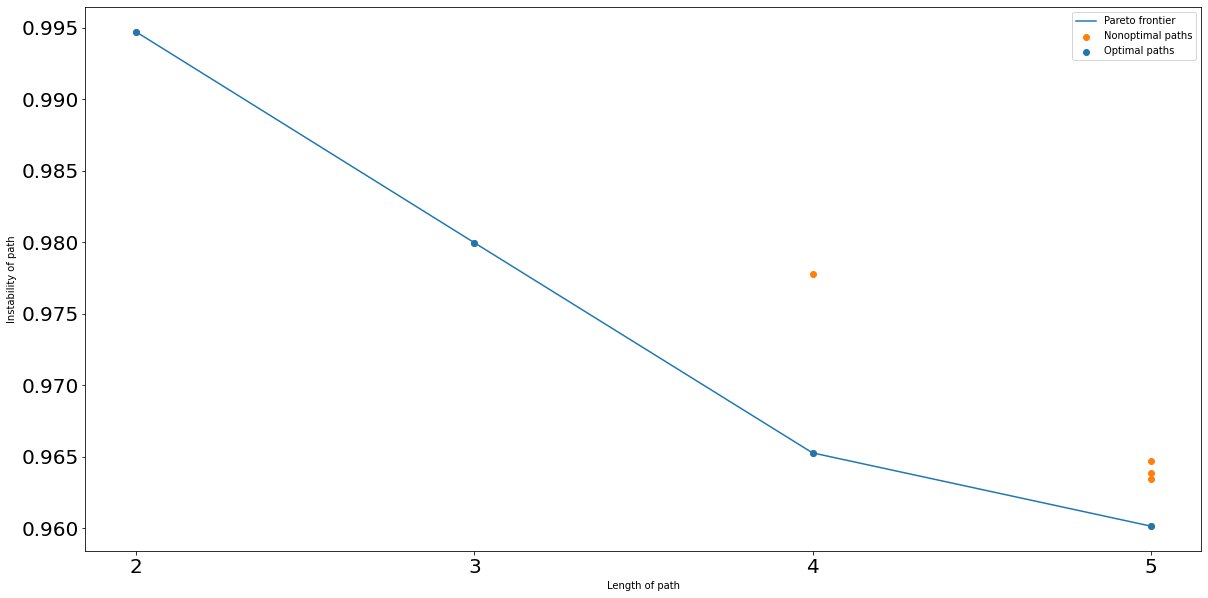

In [129]:
%%time
paths_demo(g,list(movies_map.keys())[20],list(movies_map.keys())[10])

7597


C:\Users\Alpaca\AppData\Local\Temp\ipykernel_67752\823338577.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(111)


FileNotFoundError: [Errno 2] No such file or directory: 'Output/7597_151573_samples.txt'

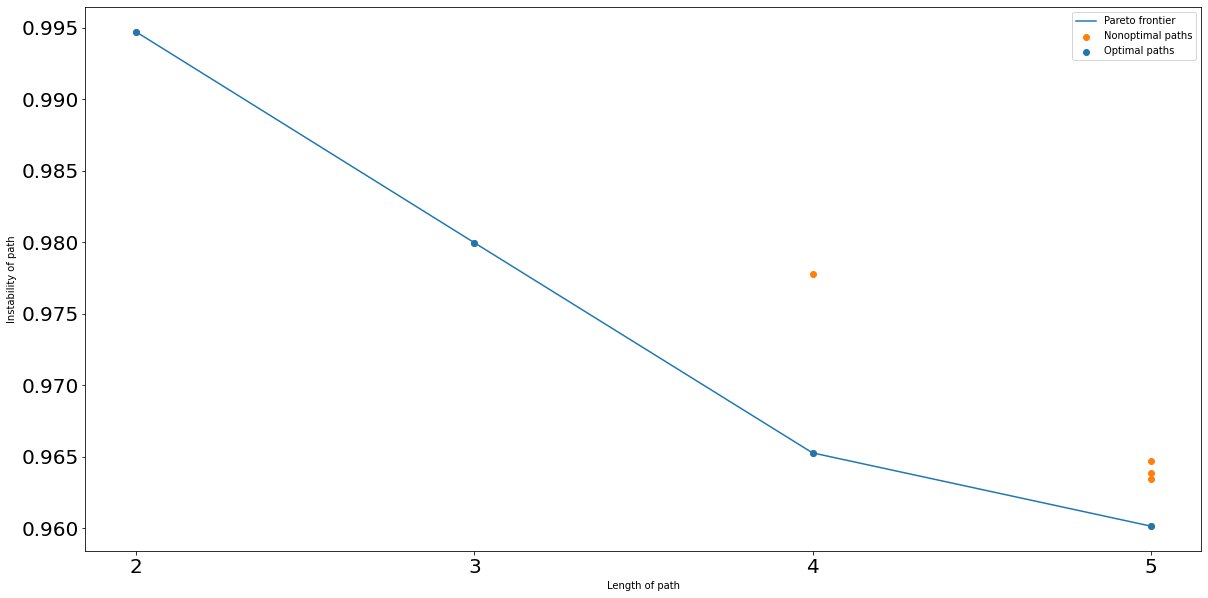

In [130]:
%%time
paths_demo(g,list(movies_map.keys())[10], list(movies_map.keys())[20])

In [131]:
paths_demo(g, transformers, notebook)

NameError: name 'transformers' is not defined

In [132]:
paths_demo(g, princess, darko)

NameError: name 'princess' is not defined

## Compute pareto frontier between $s$ and $t$

In [137]:
%%time
most_stable, all_stable_paths = paths.most_stable_paths(g, list(movies_map.keys())[10], list(movies_map.keys())[20])
#paths.draw.plot_pareto(most_stable, all_stable_paths)
# plt.savefig("movies_pareto_1.png")

#17 secs consulta sample 30k

Wall time: 82.7 ms


In [138]:
all_stable_paths

{2: [([7597, 15157], 0.9947040498442368)],
 3: [([7597, 6307, 15157], 0.9799646434885091)],
 4: [([7597, 6307, 8403, 15157], 0.9777580071174378),
  ([7597, 6307, 26607, 15157], 0.9652718124923303)],
 5: [([7597, 4415, 6307, 26607, 15157], 0.9646987218502738),
  ([7597, 14801, 6307, 26607, 15157], 0.9638377926421404),
  ([7597, 15546, 6307, 26607, 15157], 0.9634583563154991),
  ([7597, 23928, 6307, 26607, 15157], 0.9601528384279476)]}

In [139]:
%%time
def movie_names_in_path(ms):
    movies_in_path = ms[0]
    pms = [movie_info.loc[movie_info.id == m].track_name.values[0] for m in movies_in_path]
    return pms

print("\n".join(movie_names_in_path(most_stable[3])))
print()
print("\n".join(movie_names_in_path(most_stable[4])))
print()
print("\n".join(movie_names_in_path(most_stable[5])))

Whole Lotta Love
The Unforgiven
Thunder Kiss '65

Whole Lotta Love
The Unforgiven
Fuel
Thunder Kiss '65

Whole Lotta Love
Smoke On the Water
The Unforgiven
Fuel
Thunder Kiss '65
Wall time: 19.9 ms


In [140]:
most_stable

{2: ([7597, 15157], 0.9947040498442368),
 3: ([7597, 6307, 15157], 0.9799646434885091),
 4: ([7597, 6307, 26607, 15157], 0.9652718124923303),
 5: ([7597, 23928, 6307, 26607, 15157], 0.9601528384279476)}

we have pos
4
Wall time: 1min 13s


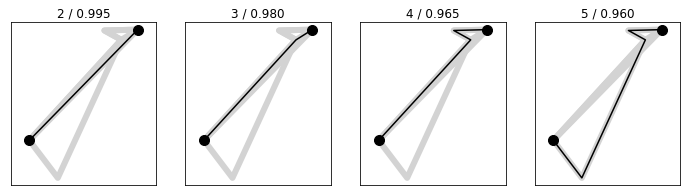

In [141]:
%%time
from matplotlib.collections import LineCollection

pos = nx.kamada_kawai_layout(g)
print('we have pos')
instability = np.array([v for _, v in most_stable.values()])

points = [np.array([pos[u] for u in path])
          for path, _ in most_stable.values()]

n = len(points)
print(n)
s = 3

plt.figure(figsize=(s*n, s))
colors = np.array(['lightgray', 'black'])

for i, path in enumerate(points):
    background = LineCollection(points, linewidth=6, color='lightgray')
    lines = LineCollection([path], color='black')
    
    ax = plt.subplot(1, n, i + 1)
    ax.add_collection(background)
    ax.add_collection(lines)
    ax.scatter(*path[[0, -1]].T, s=100, c='k', zorder=2)
    ax.autoscale_view()

    plt.axis('equal')
    plt.xticks([])
    plt.yticks([])
    plt.title(f'{len(points[i])} / {instability[i]:.3f}')
    
#plt.savefig('small_multiples_movies.png')

## Plot the pareto frontier on the graph using kamada kawaii and UMAP

In [143]:
gcc = g.subgraph(max(nx.connected_components(g), key=len))
paths.draw.draw_stable_paths(gcc, most_stable, chainsaw, mulan)

AttributeError: module 'paths' has no attribute 'draw'

In [144]:
def UMAP_positions(g, filtration):

    def distances_fast(g, vertices, vertex_map):
        """This shouldn't be used, it was a first pass, fast but not very accurate."""
        dists = np.zeros((len(vertices), len(vertices)))
        from itertools import combinations
        for s,e in combinations(vertices, 2):

            if (s,e) in g.edges:
                dists[vertex_map[e], vertex_map[s]] = g.edges[s,e]['dist']
                dists[vertex_map[s], vertex_map[e]] = g.edges[s,e]['dist']
            elif (e,s) in g.edges:
                print("edge backwards is in")
            else:
                dists[vertex_map[e], vertex_map[s]] = 10
                dists[vertex_map[s], vertex_map[e]] = 10

        return dists

    vertices = [v[0][0] for v in filtration if len(v[0]) == 1]
    vertex_map = {v:k for k,v in enumerate(vertices)}
    dists = distances_fast(g, vertices, vertex_map)
    print("Found distances")

    embedding = umap.UMAP(n_neighbors=10, metric='precomputed').fit_transform(dists)
    print("umap embedding computed")
    keys = np.array(list(vertex_map.keys()))
    pos = {k: embedding[v] for k,v in vertex_map.items()}
    
    return embedding, pos, keys

In [145]:
%%time
embedding, pos, keys = UMAP_positions(g, filtration)
#paths.draw.draw_stable_paths(g, most_stable, list(movies_map.keys())[10], list(movies_map.keys())[20], pos=pos)

Found distances


C:\Users\Alpaca\miniconda3\lib\site-packages\umap\umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


umap embedding computed
Wall time: 5.2 s


## Cluster the UMAP embedding and see how well it clustered

In [146]:
%%time
from sklearn import cluster

def genre_hist(genres_list, v, ax):
    from collections import Counter
    each = [g for x in genres_list for g in x.split('|')]
    c = dict(Counter(each))
    
    cs = []
    for m in MAJOR_CATS:
        if m in c.keys():
            cs.append(c[m])
        else:
            cs.append(0)
        
    cmap = plt.get_cmap("tab10")
    
    ax.bar(range(len(MAJOR_CATS)), cs, align='center', color=cmap(int(v)), alpha=0.5)
    ax.set_xticks(range(len(MAJOR_CATS)))
    ax.set_xticklabels( list(MAJOR_CATS), rotation=45 )

Wall time: 0 ns


Wall time: 133 ms


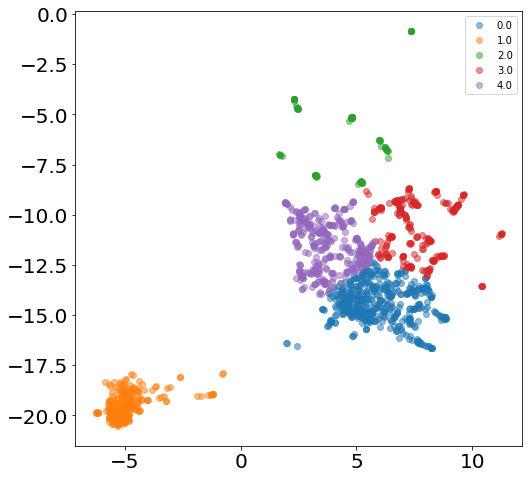

In [147]:
%%time
clusterer = cluster.KMeans(5)
clusterer.fit(embedding)

ds = np.hstack([keys.reshape(-1,1), embedding, clusterer.labels_.reshape(-1, 1)])
df = pd.DataFrame(ds, columns=['key', 'x', 'y', 'cluster'])
clusters = df.groupby('cluster')
plt.figure(figsize=(8,8))

for c, da in clusters:
    alpha = 0.5
    plt.scatter(*da[['x', 'y']].values.T, label=c, alpha=alpha)
plt.legend()

In [148]:
MAJOR_CATS

NameError: name 'MAJOR_CATS' is not defined

KeyError: 'movieId'

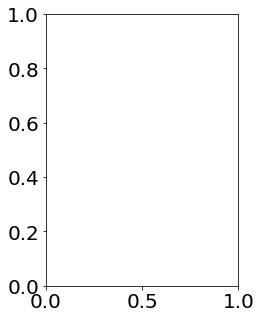

In [149]:
plt.figure(figsize=(20,5))

v = 0.0
ax = plt.subplot(151)
cluster_vals = clusters.get_group(v)['key'].values
genres_in = movie_info.loc[movie_info['movieId'].isin(cluster_vals)].genres.values
genre_hist(genres_in, v, ax)

v = 1.0
ax = plt.subplot(152)
cluster_vals = clusters.get_group(v)['key'].values
genres_in = movie_info.loc[movie_info['movieId'].isin(cluster_vals)].genres.values
genre_hist(genres_in, v, ax)

v = 2.0
ax = plt.subplot(153)
cluster_vals = clusters.get_group(v)['key'].values
genres_in = movie_info.loc[movie_info['movieId'].isin(cluster_vals)].genres.values
genre_hist(genres_in, v, ax)

v = 3.0
ax = plt.subplot(154)
cluster_vals = clusters.get_group(v)['key'].values
genres_in = movie_info.loc[movie_info['movieId'].isin(cluster_vals)].genres.values
genre_hist(genres_in, v, ax)

v = 4.0
ax = plt.subplot(155)
cluster_vals = clusters.get_group(v)['key'].values
genres_in = movie_info.loc[movie_info['movieId'].isin(cluster_vals)].genres.values
genre_hist(genres_in, v, ax)

## Look at some steps in the filtration 

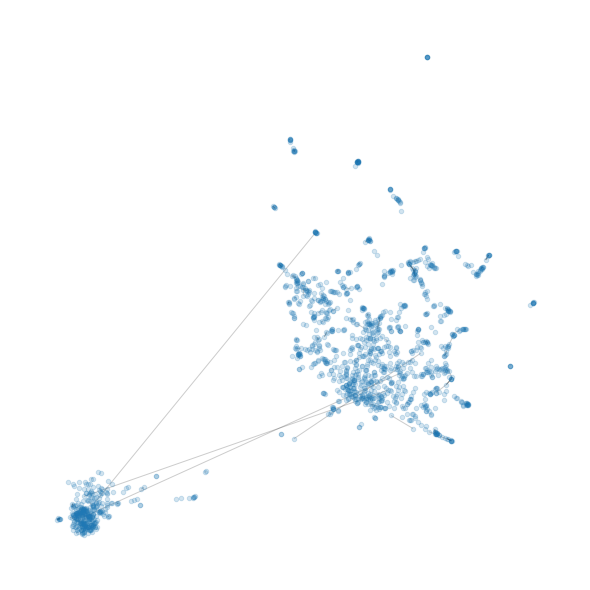

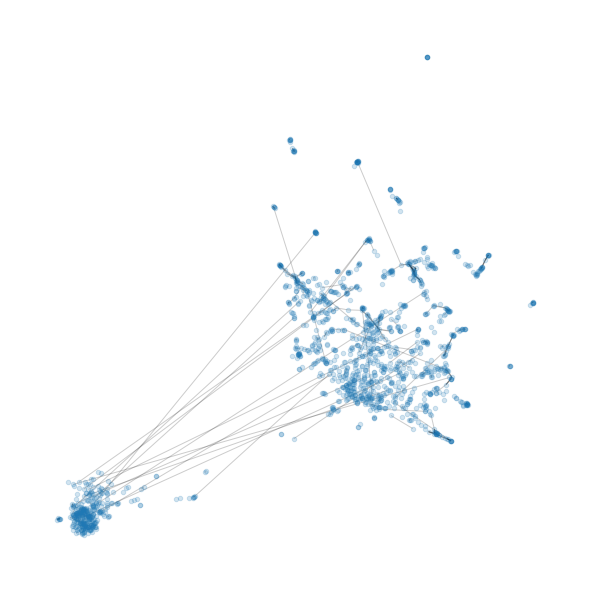

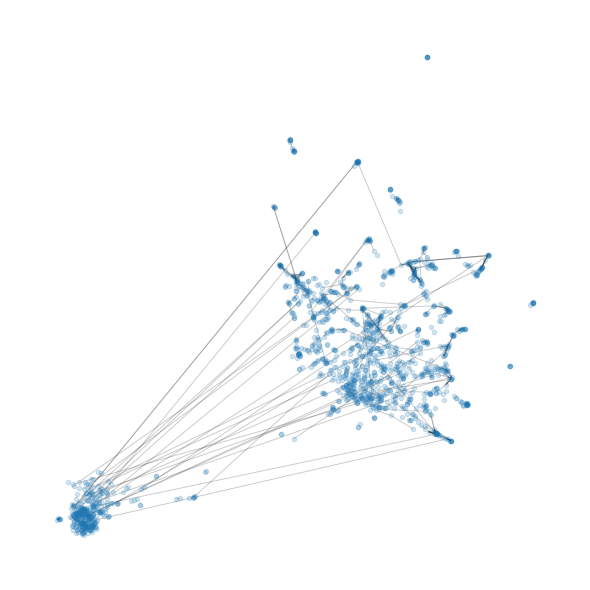

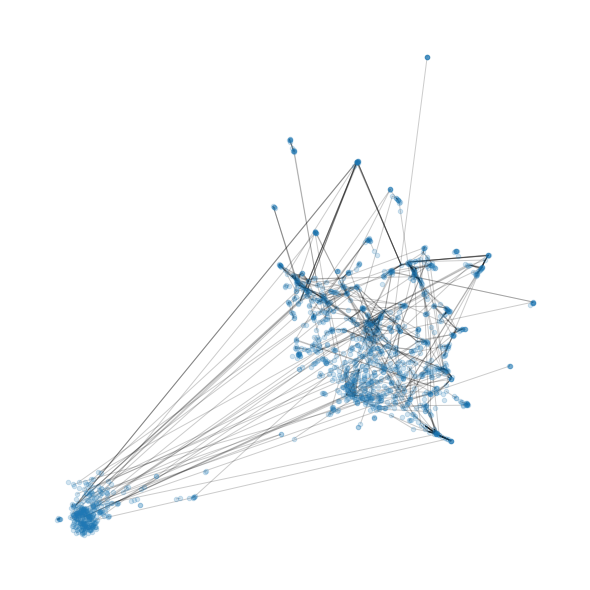

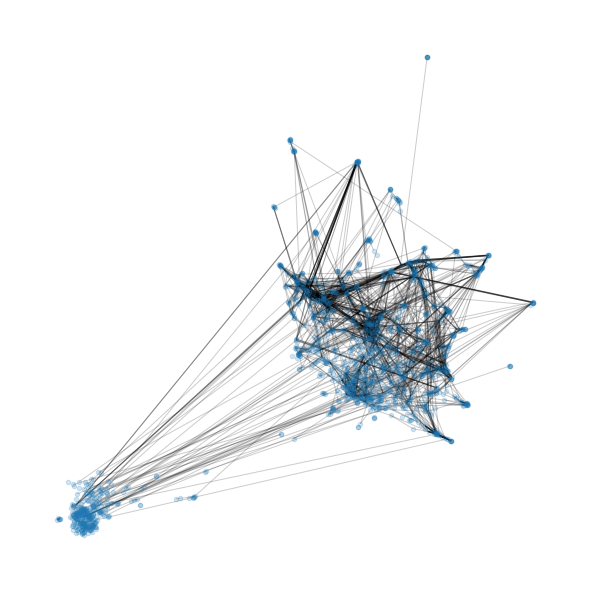

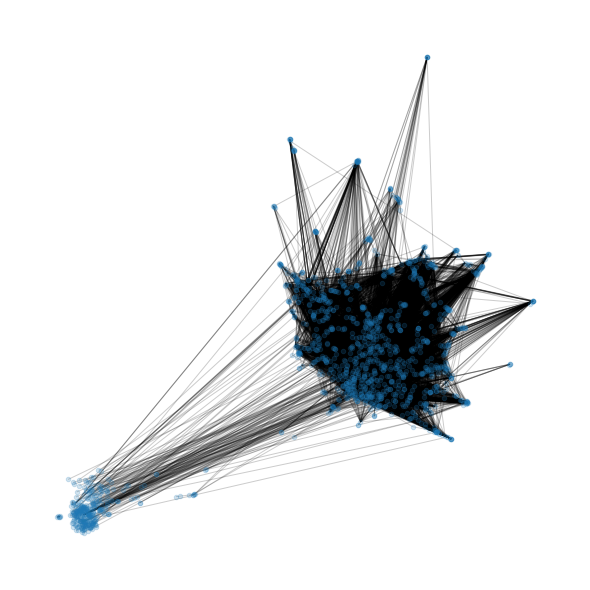

In [153]:
def filter_plot(filtration, thresh, pos=None):
    pos = pos or nx.kamada_kawai_layout()
    filtration = [f for f in filtration if f[1] < thresh]
    g = build_graph(filtration, thresh)
    
    plt.figure(figsize=(8,8))
    edges = g.edges()
    weights = [g[u][v]['dist'] for u,v in edges]
    nx.draw(g, pos=pos, node_size=20, alpha=0.2)
    plt.show()
filter_plot(filtration, 0.75, pos)
filter_plot(filtration, 0.85, pos)
filter_plot(filtration, 0.90, pos)
filter_plot(filtration, 0.95, pos)
filter_plot(filtration, 0.98, pos)
filter_plot(filtration, 1, pos)

In [375]:
g.size()

175176